I want to test that the sampler converges for many different starting conditions are true values. So I randomized the true and initial values. 

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from pymc import MCMC
import seaborn
import numpy as np
from parmed.topologyobjects import DihedralType
from simtk import unit
from torsionfit.toy_model import ToyModel
import torsionfit.backends.sqlite_plus as db

In [2]:
toy = ToyModel(n_increments=18, sample_phase=True, rj=True)

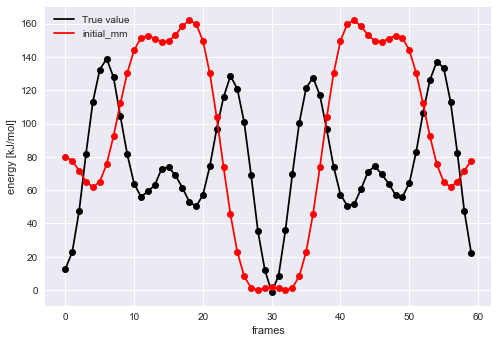

In [6]:
# Initial and True values are randomized. RJ is on and phases are discrete (0, 180)
toy = ToyModel(n_increments=30, sample_phase=True, rj=True)
plt.plot(toy.synthetic_energy, color='black', label='True value')
plt.plot(toy.synthetic_energy, 'ko')
plt.xlabel('frames')
plt.ylabel('energy [kJ/mol]')
plt.plot(toy.scan_set.mm_energy, color='r', label='initial_mm')
plt.plot(toy.scan_set.initial_mm, 'ko', color='r')
plt.legend()

In [7]:
# sample
sampler = MCMC(toy.model.pymc_parameters, db=db, dbname='discrete_phase_rj_randomized.sqlite')
sampler.sample(iter=10000)

 [-----------------100%-----------------] 10000 of 10000 complete in 703.5 sec

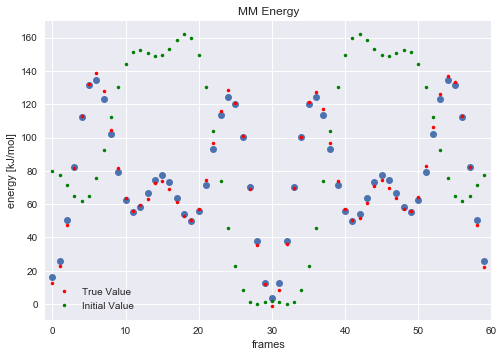

In [8]:
seaborn.tsplot(sampler.trace('mm_energy')[:], interpolate=False)
plt.plot(toy.synthetic_energy, '.', color='r', label='True Value')
plt.title('MM Energy')
plt.xlabel('frames')
plt.ylabel('energy [kJ/mol]')
#plt.plot(sampler.trace('mm_energy')[0])
plt.plot(toy.scan_set.initial_mm, '.', color='g', label='Initial Value')
plt.legend()
plt.savefig('energy_fit_discrete_randomized.pdf')

The fit looks good! Now let's see how long it takes for sigma to equilibrate.

In [9]:
import pymbar.timeseries as ts
[t, g, N_eff] = ts.detectEquilibration(sampler.trace('sigma')[:])
print('Start of equilibrated data: {}'.format(t))

Start of equilibrated data: 2328


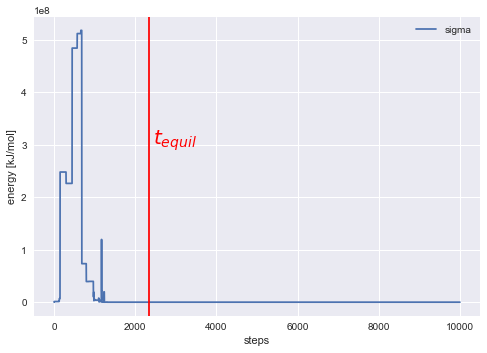

In [14]:
plt.plot(np.exp(sampler.trace('sigma')[:]), label='sigma')
plt.axvline(t, color='red')
plt.text(t+100, 300000000, r'$t_{equil}$', color='red', fontsize=20)
plt.legend()
plt.xlabel('steps')
plt.ylabel('energy [kJ/mol]')
plt.savefig('sigma_discrete_randomized.pdf')

Sigma does take longer to equilibrate but the initial value was very far off from the true value

In [18]:
print('True value of model is :')
print(toy.true_value[0])
print(toy.true_value[1])
print(toy.true_value[2])

True value of model is :
<DihedralType; phi_k=8.048, per=6, phase=180.000,  scee=1.000, scnb=1.000>
<DihedralType; phi_k=1.569, per=1, phase=0.000,  scee=1.000, scnb=1.000>
<DihedralType; phi_k=8.583, per=4, phase=180.000,  scee=1.000, scnb=1.000>


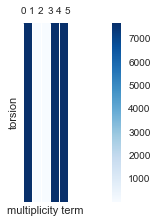

In [16]:
import torsionfit.plots as plots
plots.marg_mult(toy.model, sampler, 10000, t)
plt.savefig('multiplicity_discrete_random.pdf')

#### Traces of parameters
When the label is on, the values of the force constant (K) and phase angle converges to the true value. If the label is off, the values for K and phase are random since they don't contribute to the energy.

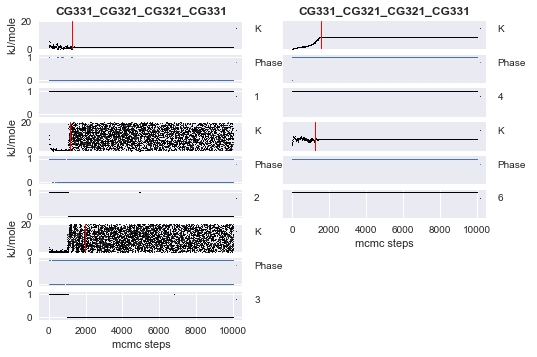

In [19]:
plots.trace_plots('CG331_CG321_CG321_CG331', sampler, markersize=2.0, filename='traces_discrete_rj_random.pdf')

### Marginal distribution of parameters
The distribution of $K_1$  is distributed around the true value, while all other K's are uniformly distributed.

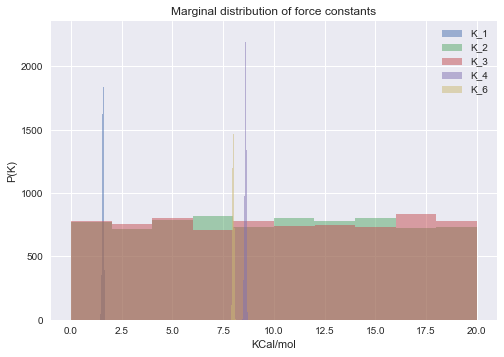

In [20]:
alpha = 0.5
plt.hist(sampler.CG331_CG321_CG321_CG331_1_K.trace[t:], label='K_1', alpha=alpha)
plt.hist(sampler.CG331_CG321_CG321_CG331_2_K.trace[t:], label='K_2', alpha=alpha)
plt.hist(sampler.CG331_CG321_CG321_CG331_3_K.trace[t:], label='K_3', alpha=alpha)
plt.hist(sampler.CG331_CG321_CG321_CG331_4_K.trace[t:], label='K_4', alpha=alpha)
plt.hist(sampler.CG331_CG321_CG321_CG331_6_K.trace[t:], label='K_6', alpha=alpha)

plt.legend()
plt.title('Marginal distribution of force constants')
plt.xlabel('KCal/mol')
plt.ylabel('P(K)')

#### Marginal distribution of parameter where label is on


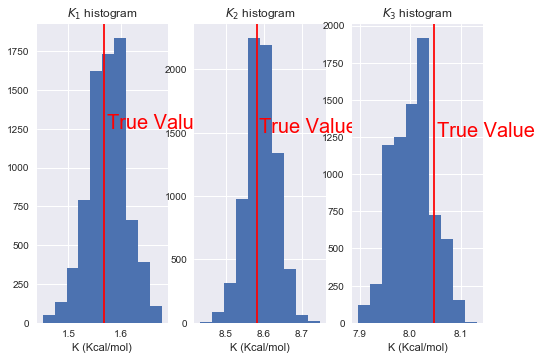

In [24]:
plt.subplot(1, 3, 1)
plt.hist(sampler.CG331_CG321_CG321_CG331_1_K.trace[t:], label='K_1')
plt.axvline(toy.true_value[1].phi_k, color='red')
plt.text(toy.true_value[1].phi_k+0.005, 1250, 'True Value', color='red', fontsize=20)
plt.title(r'$K_1$ histogram')
plt.xlabel('K (Kcal/mol)')
plt.subplot(1, 3, 2)
plt.hist(sampler.CG331_CG321_CG321_CG331_4_K.trace[t:], label='K_4')
plt.axvline(toy.true_value[2].phi_k, color='red')
plt.text(toy.true_value[2].phi_k+0.005, 1500, 'True Value', color='red', fontsize=20)
plt.xlabel('K (Kcal/mol)')
plt.title(r'$K_2$ histogram')
plt.subplot(1, 3, 3)
plt.hist(sampler.CG331_CG321_CG321_CG331_6_K.trace[t:], label='K_6')
plt.axvline(toy.true_value[0].phi_k, color='red')
plt.text(toy.true_value[0].phi_k+0.005, 1250, 'True Value', color='red', fontsize=20)
plt.title(r'$K_3$ histogram')
plt.xlabel('K (Kcal/mol)')
plt.savefig('hist_randomized.pdf')

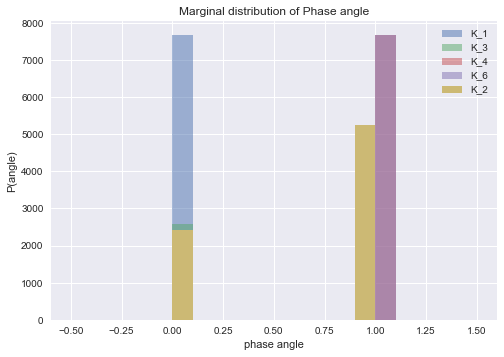

In [25]:
alpha = 0.5
plt.hist(sampler.CG331_CG321_CG321_CG331_1_Phase.trace[t:], label='K_1', alpha=alpha)
plt.hist(sampler.CG331_CG321_CG321_CG331_3_Phase.trace[t:], label='K_3', alpha=alpha)
plt.hist(sampler.CG331_CG321_CG321_CG331_4_Phase.trace[t:], label='K_4', alpha=alpha)
plt.hist(sampler.CG331_CG321_CG321_CG331_6_Phase.trace[t:], label='K_6', alpha=alpha)
plt.hist(sampler.CG331_CG321_CG321_CG331_2_Phase.trace[t:], label='K_2')


plt.legend()
plt.title('Marginal distribution of Phase angle')
plt.xlabel('phase angle')
plt.ylabel('P(angle)')